<a href="https://colab.research.google.com/github/SoungbinC/RETFoundModel-with-heatmap/blob/main/RETFound_heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp /content/drive/MyDrive/retina_models/retfound_best_epoch5.pth /content/


In [3]:
!pip install kagglehub
import kagglehub

path = kagglehub.dataset_download("gunavenkatdoddi/eye-diseases-classification")
print("Downloaded to:", path)


Downloaded to: /kaggle/input/eye-diseases-classification


In [4]:
import shutil

local_path = path  # the one returned by kagglehub
shutil.copytree(local_path, "/content/eye_diseases", dirs_exist_ok=True)

'/content/eye_diseases'

In [5]:
!git clone https://github.com/rmaphoh/RETFound_MAE.git
%cd RETFound_MAE


fatal: destination path 'RETFound_MAE' already exists and is not an empty directory.
/content/RETFound_MAE


In [6]:
from models_vit import RETFound_mae  # or your correct model import
import torch
model = RETFound_mae(num_classes=4)  # or 5, depending on your labels
model.load_state_dict(torch.load("/content/retfound_best_epoch5.pth"))
model.eval().cuda()


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Id

In [7]:
# Patch the timm Attention module to store attn_map
def patched_attention_forward(self, x):
    B, N, C = x.shape
    qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
    q, k, v = qkv.permute(2, 0, 3, 1, 4)

    attn = (q @ k.transpose(-2, -1)) * self.scale
    attn = attn.softmax(dim=-1)
    self.attn_map = attn.detach()  # 👈 Save attention weights here

    attn = self.attn_drop(attn)
    x = (attn @ v).transpose(1, 2).reshape(B, N, C)
    x = self.proj(x)
    x = self.proj_drop(x)
    return x

# Apply the patch to all attention layers
for blk in model.blocks:
    blk.attn.forward = patched_attention_forward.__get__(blk.attn, blk.attn.__class__)


In [8]:
def get_attention_rollout(model, input_tensor, discard_ratio=0.9):
    attn_weights = []

    def hook_fn_forward(module, input, output):
        if hasattr(module, 'attn_map'):
            attn_weights.append(module.attn_map.cpu())
        else:
            print("⚠️ Attention weights not found.")

    handles = []
    attn_layers = model.blocks[-4:]  # last 4 blocks
    for blk in attn_layers:
        h = blk.attn.register_forward_hook(hook_fn_forward)
    # Run forward to trigger hooks
    _ = model(input_tensor)

    for h in handles:
        h.remove()

    if not attn_weights:
        raise ValueError("No attention weights were collected.")

    result = torch.eye(attn_weights[0].size(-1))
    for attn in attn_weights:
        attn_mean = attn.mean(dim=1)
        flat = attn_mean.view(attn_mean.size(0), -1)
        _, indices = flat.topk(int(flat.size(1) * discard_ratio), dim=1, largest=False)
        flat.scatter_(1, indices, 0)
        attn_pruned = flat.view_as(attn_mean)
        attn_pruned = attn_pruned / attn_pruned.sum(dim=-1, keepdim=True)
        result = attn_pruned @ result

    mask = result[0, 0, 1:]
    heatmap = mask.reshape(14, 14).numpy()
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    return heatmap


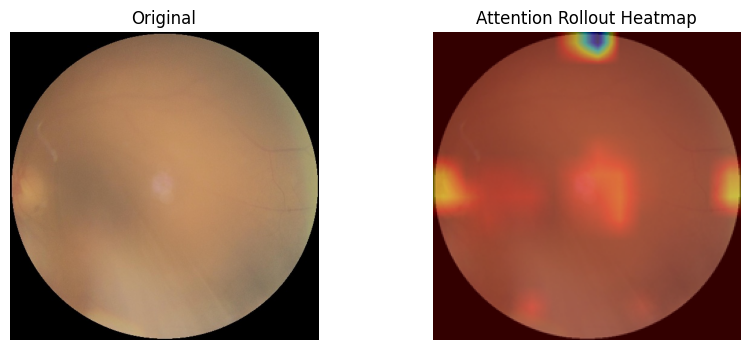

In [9]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Prepare image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
image_path = "/content/eye_diseases/dataset/cataract/103_left.jpg"
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).cuda()

# Generate heatmap
heatmap = get_attention_rollout(model, input_tensor)

# Overlay heatmap
heatmap_resized = cv2.resize(heatmap, (224, 224))
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
image_np = np.array(image.resize((224, 224)))
overlay = cv2.addWeighted(image_np.astype(np.uint8), 0.6, heatmap_color, 0.4, 0)

# Display
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("Attention Rollout Heatmap")
plt.axis("off")
plt.show()


In [10]:
!git clone https://github.com/hila-chefer/Transformer-Explainability.git
%cd Transformer-Explainability


fatal: destination path 'Transformer-Explainability' already exists and is not an empty directory.
/content/RETFound_MAE/Transformer-Explainability


In [11]:
import os, shutil
from sklearn.model_selection import train_test_split

source_dir = "/content/eye_diseases/dataset"
output_base = "/content/eye_diseases_split"
os.makedirs(output_base, exist_ok=True)

splits = ["train", "val", "test"]
for split in splits:
    for cls in os.listdir(source_dir):
        os.makedirs(os.path.join(output_base, split, cls), exist_ok=True)

# Split per class
for cls in os.listdir(source_dir):
    images = os.listdir(os.path.join(source_dir, cls))
    train_val, test = train_test_split(images, test_size=0.2, random_state=42)
    train, val = train_test_split(train_val, test_size=0.2, random_state=42)

    for img in train:
        shutil.copy(os.path.join(source_dir, cls, img), os.path.join(output_base, "train", cls, img))
    for img in val:
        shutil.copy(os.path.join(source_dir, cls, img), os.path.join(output_base, "val", cls, img))
    for img in test:
        shutil.copy(os.path.join(source_dir, cls, img), os.path.join(output_base, "test", cls, img))

print("✅ Dataset split into train/val/test.")


✅ Dataset split into train/val/test.


In [12]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_dataset = ImageFolder("/content/eye_diseases_split/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [13]:
# Clean model without explanation logic
model = RETFound_mae(num_classes=4)  # or 5
model.load_state_dict(torch.load("/content/retfound_best_epoch5.pth"))
model = model.eval().cuda()


In [14]:
import torch
import pandas as pd
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os

# Reverse label index
idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}

# Tracking predictions
results = []

model.eval()
with torch.no_grad():
    for image_tensor, label in test_loader:
        image_tensor = image_tensor.cuda()
        label = label.item()

        outputs = model(image_tensor)
        probs = torch.softmax(outputs, dim=1)
        conf, pred = torch.max(probs, dim=1)

        pred_class = pred.item()
        is_correct = (pred_class == label)

        image_path = test_loader.dataset.samples[len(results)][0]  # get actual file path

        results.append({
            "Image": os.path.basename(image_path),
            "True Label": idx_to_class[label],
            "Predicted Label": idx_to_class[pred_class],
            "Confidence": round(conf.item(), 4),
            "Correct": is_correct
        })

# Convert to DataFrame
df = pd.DataFrame(results)

# Save for review
df.to_csv("retfound_prediction_results.csv", index=False)
print("✅ Saved to retfound_prediction_results.csv")

# Show stats
accuracy = df["Correct"].mean()
print(f"\n🎯 Test Accuracy: {accuracy:.4f}")
print("✅ Correct predictions:", df['Correct'].sum())
print("❌ Incorrect predictions:", (~df['Correct']).sum())

# Optional: show some false predictions
print("\n📉 Sample incorrect predictions:")
print(df[~df["Correct"]].head(5))


✅ Saved to retfound_prediction_results.csv

🎯 Test Accuracy: 0.9396
✅ Correct predictions: 794
❌ Incorrect predictions: 51

📉 Sample incorrect predictions:
               Image            True Label Predicted Label  Confidence  \
3     1144_right.jpg              cataract          normal      0.9796   
22    2140_right.jpg              cataract          normal      0.6135   
48     2225_left.jpg              cataract          normal      0.8813   
360  11229_left.jpeg  diabetic_retinopathy          normal      0.9970   
429    1212_left.jpg              glaucoma          normal      0.7775   

     Correct  
3      False  
22     False  
48     False  
360    False  
429    False  


In [15]:
# Treat "normal" as negative, others as positive
df["is_positive"] = df["True Label"] != "normal"
df["pred_positive"] = df["Predicted Label"] != "normal"

# True/False Positive/Negative flags
df["TP"] = (df["is_positive"]) & (df["pred_positive"]) & (df["Correct"])
df["TN"] = (~df["is_positive"]) & (~df["pred_positive"]) & (df["Correct"])
df["FP"] = (~df["is_positive"]) & (df["pred_positive"]) & (~df["Correct"])
df["FN"] = (df["is_positive"]) & (~df["pred_positive"]) & (~df["Correct"])

# Print counts
tp = df["TP"].sum()
tn = df["TN"].sum()
fp = df["FP"].sum()
fn = df["FN"].sum()

print(f"""
✅ True Positives (TP): {tp}
✅ True Negatives (TN): {tn}
❌ False Positives (FP): {fp}
❌ False Negatives (FN): {fn}
""")

# Optional: Accuracy, Precision, Recall
precision = tp / (tp + fp + 1e-8)
recall = tp / (tp + fn + 1e-8)
f1 = 2 * precision * recall / (precision + recall + 1e-8)

print(f"🎯 Binary Accuracy: {(tp + tn) / len(df):.4f}")
print(f"🎯 Precision: {precision:.4f}")
print(f"🎯 Recall: {recall:.4f}")
print(f"🎯 F1 Score: {f1:.4f}")



✅ True Positives (TP): 589
✅ True Negatives (TN): 205
❌ False Positives (FP): 10
❌ False Negatives (FN): 35

🎯 Binary Accuracy: 0.9396
🎯 Precision: 0.9833
🎯 Recall: 0.9439
🎯 F1 Score: 0.9632


In [16]:
# Filter only false negatives (disease misclassified as normal)
false_negatives = df[(df["True Label"] != "normal") & (df["Predicted Label"] == "normal") & (~df["Correct"])]

# Count how many times each disease was missed
missed_counts = false_negatives["True Label"].value_counts()

# Display
print("🩺 Diseases most often missed by the model:\n")
print(missed_counts)


🩺 Diseases most often missed by the model:

True Label
glaucoma                31
cataract                 3
diabetic_retinopathy     1
Name: count, dtype: int64


In [17]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# Load LRP modules from Hila Chefer's repo
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

# Image preprocessing
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# Helper to overlay heatmap on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# 🔍 Main function: Run ViT LRP and show heatmap
def visualize_retina_heatmap_vitl(image_path, class_index=None):
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).requires_grad_().cuda()

    # Load ViT and LRP
    model = vit_LRP(pretrained=True).cuda().eval()
    explainer = LRP(model)

    # Generate LRP attribution map
    attribution = explainer.generate_LRP(input_tensor, method="transformer_attribution").squeeze()
    attribution = attribution.detach().cpu().numpy().reshape(14, 14)
    attribution = cv2.resize(attribution, (224, 224))
    attribution = (attribution - attribution.min()) / (attribution.max() - attribution.min())

    # Prepare original image
    image_np = transform(image).permute(1, 2, 0).numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    # Create heatmap overlay
    cam = show_cam_on_image(image_np, attribution)
    cam = np.uint8(255 * cam)
    cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cam)
    plt.title("ViT-LRP Heatmap")
    plt.axis("off")
    plt.show()




In [18]:
import os

# Assume your test images are under this path:
test_root = "/content/eye_diseases_split/test"

# Function to find full path of an image
def resolve_image_path(row):
    for label_dir in os.listdir(test_root):
        full_path = os.path.join(test_root, label_dir, row["Image"])
        if os.path.exists(full_path):
            return full_path
    return None

# Add a new column with the full image path
df["image_path"] = df.apply(resolve_image_path, axis=1)


In [19]:
true_positives = df[
    (df["True Label"] != "normal") &
    (df["True Label"] == df["Predicted Label"]) &
    (df["Correct"] == True)
]


In [20]:
import numpy as np

def measure_central_focus_ratio(heatmap, center_fraction=0.3):
    """
    Measures the proportion of total attention within the central area of the heatmap.

    Args:
        heatmap (np.ndarray): 2D array (normalized 0–1) of size (H, W)
        center_fraction (float): proportion of width and height to consider as center (e.g. 0.3 → center 30%)

    Returns:
        float: ratio of heatmap activation in center region vs total
    """
    h, w = heatmap.shape
    ch = int(h * center_fraction)
    cw = int(w * center_fraction)

    top = (h - ch) // 2
    left = (w - cw) // 2

    center_patch = heatmap[top:top+ch, left:left+cw]
    total_focus = heatmap.sum()
    center_focus = center_patch.sum()

    return center_focus / total_focus if total_focus > 0 else 0


In [21]:
def show_cam_on_image_with_center_box(img, mask, center_fraction=0.3):
    """
    Overlay heatmap on image and draw central attention box.
    """
    h, w, _ = img.shape
    ch, cw = int(h * center_fraction), int(w * center_fraction)
    top = (h - ch) // 2
    left = (w - cw) // 2

    # Generate heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + np.float32(img)
    overlay = overlay / np.max(overlay)
    overlay = np.uint8(255 * overlay)

    # Draw rectangle for central region
    overlay = cv2.rectangle(
        overlay,
        (left, top),
        (left + cw, top + ch),
        color=(255, 255, 255),  # white border
        thickness=2
    )

    return overlay


True Positive – Central Attention: 17.07%
False Negative – Central Attention: 10.23%
False Positive – Central Attention: 10.86%


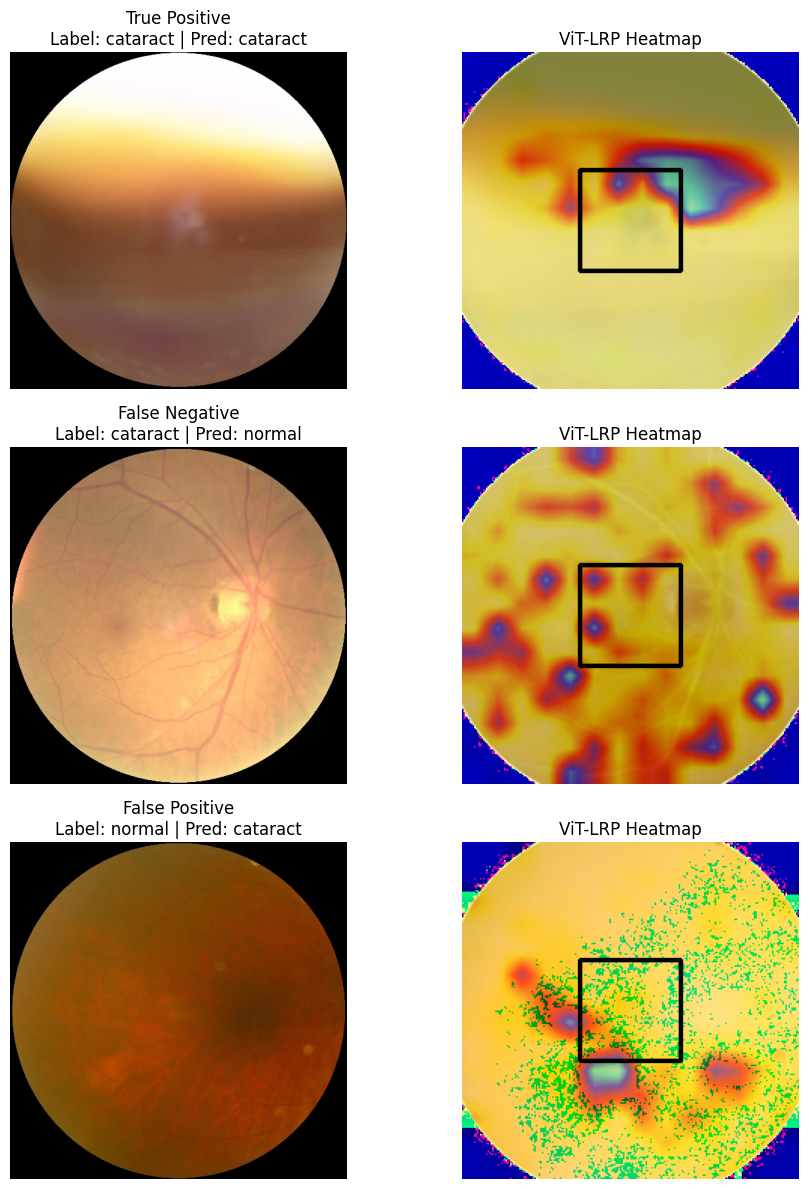

In [22]:
import matplotlib.pyplot as plt

# Pick one sample from each category
tp = df[(df["True Label"] == "cataract") & (df["Predicted Label"] == "cataract") & (df["Correct"])].iloc[0]
fn = df[(df["True Label"] == "cataract") & (df["Predicted Label"] == "normal") & (~df["Correct"])].iloc[0]
fp = df[(df["True Label"] == "normal") & (df["Predicted Label"] == "cataract") & (~df["Correct"])].iloc[0]

samples = [("True Positive", tp), ("False Negative", fn), ("False Positive", fp)]

fig, axs = plt.subplots(3, 2, figsize=(10, 12))

for i, (title, row) in enumerate(samples):
    image = Image.open(row["image_path"]).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).requires_grad_().cuda()

    # Load model and explainer (or reuse outside loop if memory allows)
    model = vit_LRP(pretrained=True).cuda().eval()
    explainer = LRP(model)

    attribution = explainer.generate_LRP(input_tensor, method="transformer_attribution").squeeze()
    attribution = attribution.detach().cpu().numpy().reshape(14, 14)
    heatmap = cv2.resize(attribution, (224, 224))
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    # Normalize and prepare original image
    img_np = transform(image).permute(1, 2, 0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    overlay = show_cam_on_image_with_center_box(img_np, heatmap)
    overlay = np.uint8(255 * overlay)
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    axs[i, 0].imshow(image)
    axs[i, 0].set_title(f"{title}\nLabel: {row['True Label']} | Pred: {row['Predicted Label']}")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(overlay)
    axs[i, 1].set_title("ViT-LRP Heatmap")
    axs[i, 1].axis("off")

    torch.cuda.empty_cache()
    # Measure central attention
    central_ratio = measure_central_focus_ratio(heatmap)
    print(f"{title} – Central Attention: {central_ratio:.2%}")

plt.tight_layout()
plt.show()


In [23]:
central_ratios = []

model = vit_LRP(pretrained=True).cuda().eval()
explainer = LRP(model)

for i, row in df.iterrows():
    image = Image.open(row["image_path"]).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).requires_grad_().cuda()

    # Use simple ViT model + LRP explainer

    attribution = explainer.generate_LRP(input_tensor, method="transformer_attribution").squeeze()
    attribution = attribution.detach().cpu().numpy().reshape(14, 14)
    heatmap = cv2.resize(attribution, (224, 224))
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    # Measure central ratio
    ratio = measure_central_focus_ratio(heatmap)
    central_ratios.append(ratio)

    torch.cuda.empty_cache()
    del input_tensor, attribution

df["Central Attention"] = central_ratios


<ipython-input-24-3ff122b36169>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="True Label", y="Central Attention", palette="Set3")
<ipython-input-24-3ff122b36169>:11: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


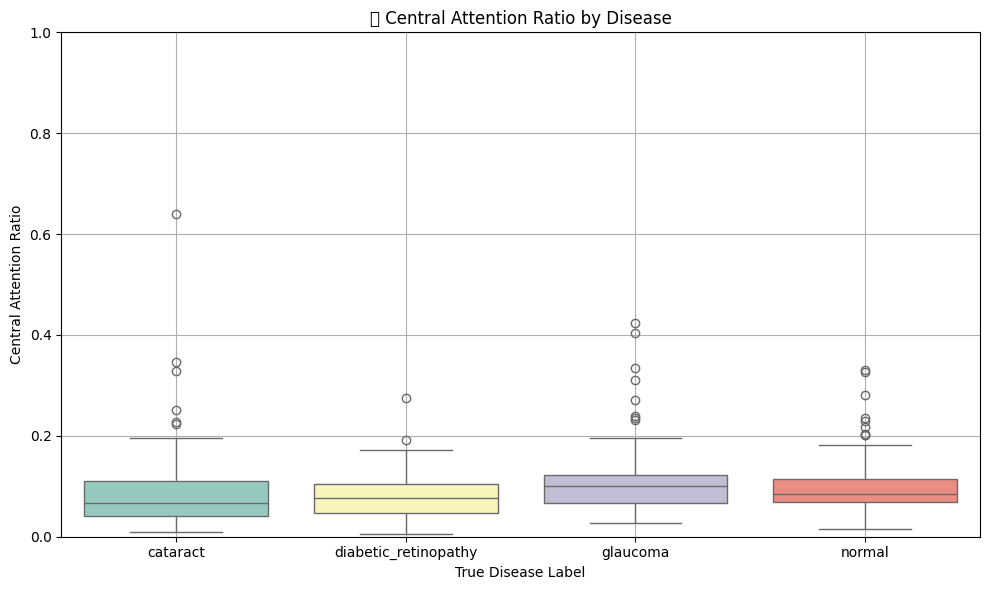

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="True Label", y="Central Attention", palette="Set3")
plt.title("🧠 Central Attention Ratio by Disease")
plt.ylabel("Central Attention Ratio")
plt.xlabel("True Disease Label")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()
